# internal wave dispersion relationship

See `argo_profiles.ipynb` notebook for more details about argo profiles.

To do:

- [X] add example of periodic fluctuation distortion
- [ ] fill bottom profiles with WOA
- [ ] add iwave reflection solution along with seafloor temperature anomaly perspective


In [1]:
from glob import glob

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import gsw

---
## load Argo data

Should extrapolate at the bottom with climatology at the bottom

In [2]:
data_dir = "argo/"
nc_files = glob(data_dir+"/*.nc")[:-1] # last files has issues don't know why
codes = [f.split("_")[-1].replace(".nc","") for f in nc_files]
print(codes)

['6902969', '6901250', '6902954', '3901849']


In [3]:
### utils 

hours = 3600
days = 86400

def load_nc(f):
    """ load argo file and massage
    """
    ds = xr.open_dataset(f)
    
    #print(f, ds)
        
    # required for profile plots (weird ...)
    ds = ds.transpose("DEPTH", "TIME", "LATITUDE", "LONGITUDE", "POSITION")    
    #
    ds = ds.assign_coords(z = -ds.DEPTH )
    ds["lon"] = ("TIME", ds.LONGITUDE.values)
    ds["lat"] = ("TIME", ds.LATITUDE.values)
    lon = ds.PRES*0 + ds.lon
    lat = ds.PRES*0 + ds.lat
    #
    ds["SA"] = gsw.SA_from_SP(ds.PSAL, ds.PRES, lon, lat) # absolute Salinity
    ds["CT"] = gsw.CT_from_t(ds.SA, ds.TEMP, ds.PRES) # conservative temperature
    ds["PT"] = gsw.pt_from_CT(ds.SA, ds.CT) # potential temperature
    ds["sigma0"] = gsw.sigma0(ds.SA, ds.CT)
    #
    N2, p_mid = gsw.Nsquared(ds.SA, ds.CT, ds.PRES, lat=0, axis=0)    
    #print(N2.shape, N2[:,1], p_mid[:,2])
    #z_mid = gsw.z_from_p(p_mid, ds.lat.values)
    #ds["DEPTH_MID"] = (("DEPTH_MID"), -np.nanmean(z_mid, axis=1))
    ds["DEPTH_MID"] = (("DEPTH_MID"), ds.DEPTH.values[:-1])
    ds = ds.assign_coords(z_mid=-ds.DEPTH_MID)
    ds["N2"] = (("DEPTH_MID", "TIME"), N2)
        
    # filter bad profiles (custom)
    flag = ds.PSAL.fillna(0).mean("DEPTH")
    ds = ds.where(flag>0, drop=True)
        
    return ds

def plot_profiles(ds):
    """ plot basic variables
    """

    fig, axes = plt.subplots(2,2, figsize=(10,10))
    _axes = axes.flatten()
    
    variables = ["PT", "SA", "sigma0", "N2"]
    for v, ax in zip(variables, _axes[:len(variables)]):
        da = ds[v]
        if "z" in da.coords:
            z_coord = "z"
        else:
            z_coord = "z_mid"
        da.plot.line(y=z_coord, add_legend=False, ax=ax)
        ax.grid()
        ax.set_xlabel("")
        ax.set_title(v)
    return axes

def smooth(ds, dz=30, depth_max=1000):
    """ smooth vertical profile """
    depth_bins = np.arange(0, depth_max, dz)
    depth = (depth_bins[:-1] + depth_bins[1:])*0.5
    _ds = (ds
          .groupby_bins("DEPTH", bins=depth_bins, labels=depth)
          .mean()
          .rename(DEPTH_bins="DEPTH")
          .drop(["N2", "z_mid", "DEPTH_MID"])
         )
    _ds = _ds.assign_coords(z=-_ds.DEPTH)
    #
    N2 = (ds["N2"]
          .groupby_bins("DEPTH_MID", bins=depth_bins, labels=depth)
          .mean()
          .rename(DEPTH_MID_bins="DEPTH_MID")
         )
    N2 = N2.assign_coords(z_mid=-N2.DEPTH_MID)
    #
    ds = xr.merge([N2, _ds])
    return ds

In [4]:
data = {int(c): load_nc(f) for f, c in zip(nc_files, codes)}

Data nearby the cable (from EuroArgo maps):

- Float 6901250 (cycles 137, 38)
- Float 6902969 (cycles 32)

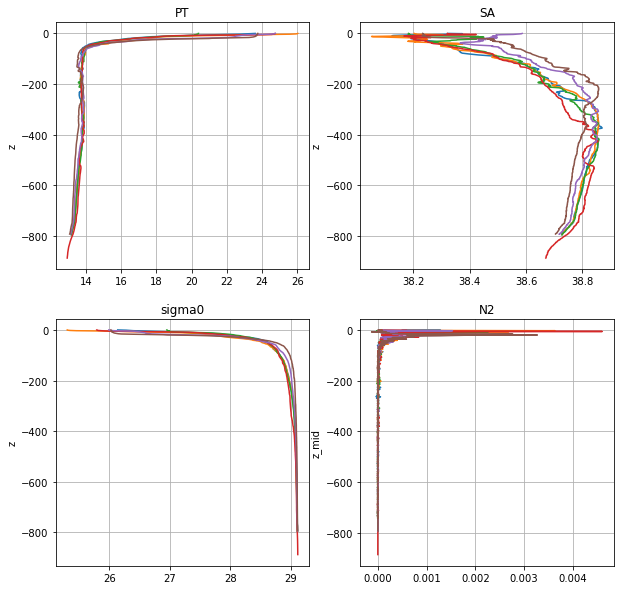

In [5]:
ds = data[6902969] # 900m max
#ds = data[6901250] # 100m max
#ds = data[6902954] # 800m max
#ds = data[3901849] # 160m max

ds_smooth = smooth(ds)

plot_profiles(ds);

(13.0, 14.0)

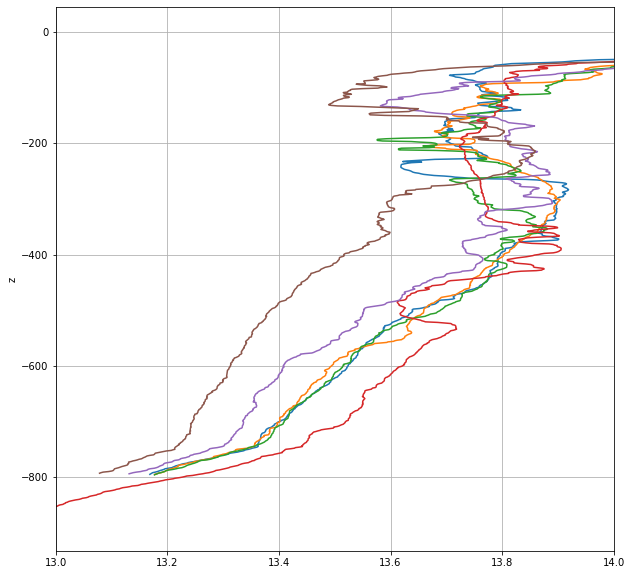

In [6]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

_da = ds["PT"]

_da.plot.line(y="z", add_legend=False, ax=ax)
ax.grid()
ax.set_xlabel("")
#ax.set_title(v)
ax.set_xlim((13,14))
#ax.set_ylim()

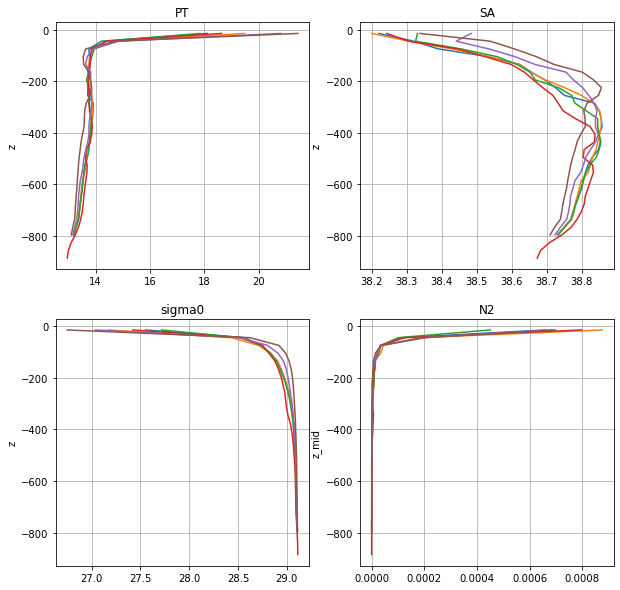

In [7]:
plot_profiles(ds_smooth);

(0.0, 1e-05)

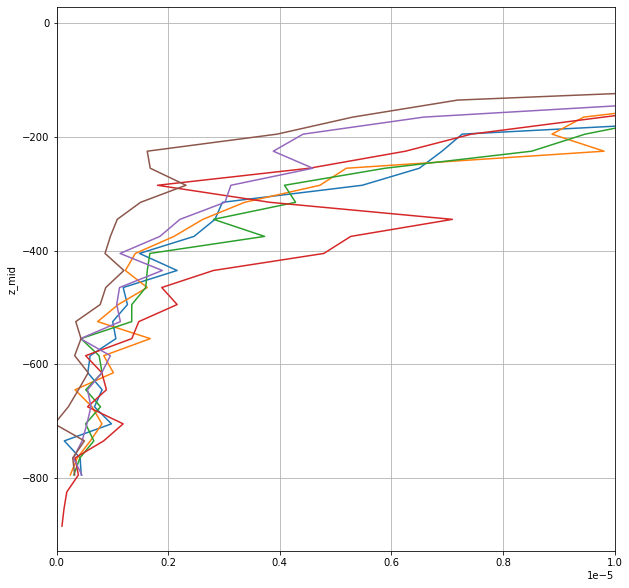

In [8]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

_da = ds["N2"]
_da = ds_smooth["N2"]

_da.plot.line(y="z_mid", add_legend=False, ax=ax)
ax.grid()
ax.set_xlabel("")
#ax.set_title(v)
ax.set_xlim((0,1e-5))
#ax.set_ylim()

Typical $N^2$ values are around $1-2 \times 10^{-6}$

/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


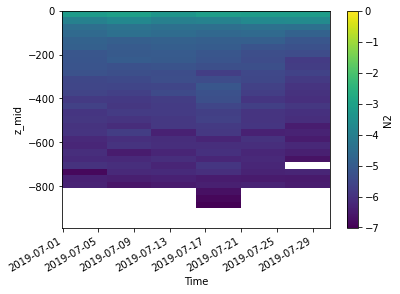

In [9]:
np.log10(ds_smooth.N2).plot(y="z_mid", vmax=0); # in cycles per hours

---

## periodic fluctuation distortion

Assume a periodic vertical displacement of the Argo profiles, how will it look like:

$
\begin{align}
T(z, t) &= \overline{T}[z - \eta(t) ], \\
\eta(t) &= \eta_0 \cos(\omega t),
\end{align}
$

Frequency does not matter here, but the amplitude and depth will.


(13.2, 14.2)

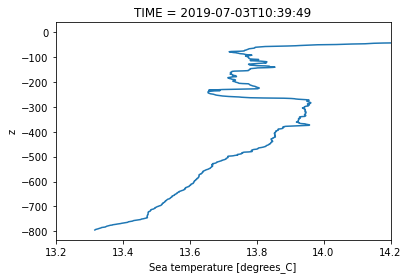

In [10]:
# select one ARGO profile
dsp = ds.isel(TIME=0).rename(DEPTH="depth")

fig, ax = plt.subplots(1,1, ) # figsize=(10,10)
dsp["TEMP"].plot(y="z")
ax.set_xlim(13.2, 14.2)

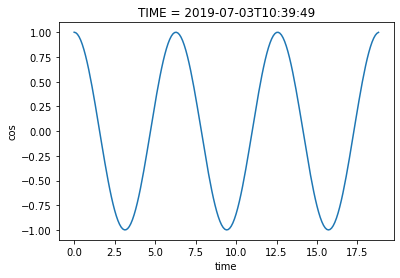

In [11]:
dst = xr.Dataset(dict(time=np.arange(0,3*2*np.pi,.1),
                      eta0=[2, 10, 100],
                      depth0=[100, 200, 600],
                     )
                )
dst["cos"] = np.cos(dst.time)

eta0_max = float(dst.eta0.max())

temp_var = "TEMP"
temp_var = "PT"

# interpolate the depth according to prescribed vertical displacements
dst["TEMP"] = dsp[temp_var].interp(depth=dst.depth0 - dst.eta0*dst.cos)

dst.cos.plot()

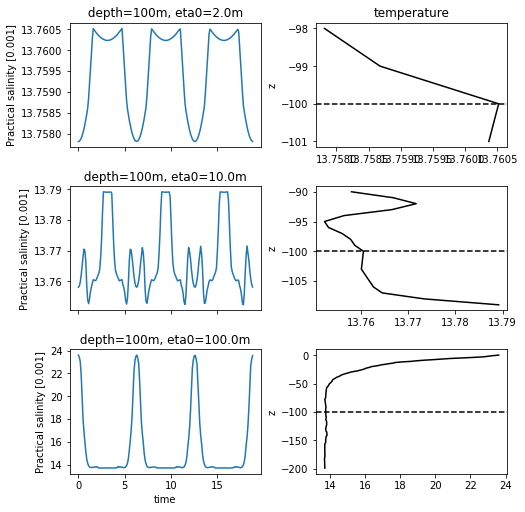

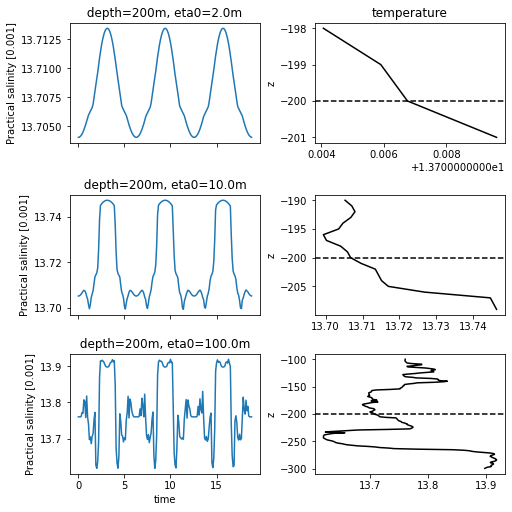

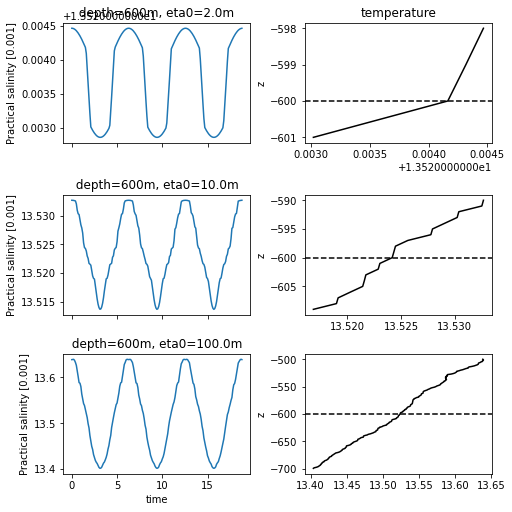

In [12]:
for d in dst.depth0:
    _ds = dst.sel(depth0=d)
    axes_left = range(_ds.eta0.size)
    fig, axd = plt.subplot_mosaic([[f"left_{k}", f"right_{k}"] for k in axes_left],
                              figsize=(7, 7), constrained_layout=True)
    #fig, axes = plt.subplots(,1,)
    for _eta, k in zip(_ds.eta0, axes_left):
        ax = axd[f"left_{k}"]
        _ds["TEMP"].sel(eta0=_eta).plot.line(ax=ax, x="time")
        ax.set_title(f" depth={float(d):.0f}m, eta0={float(_eta):.1f}m ")
        if k is not axes_left[-1]:
            ax.set_xticklabels("")
            ax.set_xlabel("")
        # zoom on temperature profile
        ax = axd[f"right_{k}"]
        dsp[temp_var].sel(depth=slice(int(d-_eta), int(d+_eta))).plot(ax=ax, y="z", color="k")
        ax.axhline(-float(d), color="k", ls="--")
        if k is axes_left[0]:
            ax.set_title("temperature")
        else:
            ax.set_title("")
        ax.set_xlabel("")

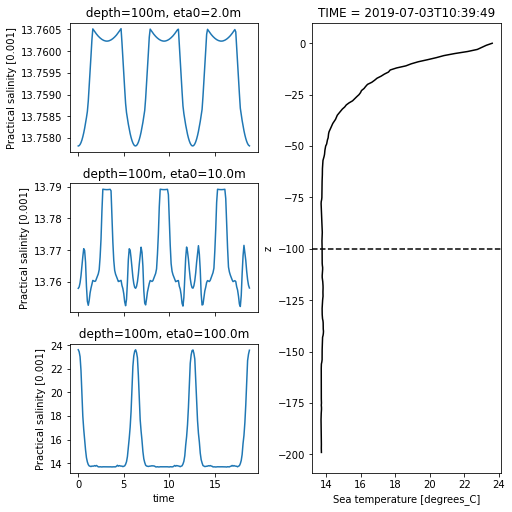

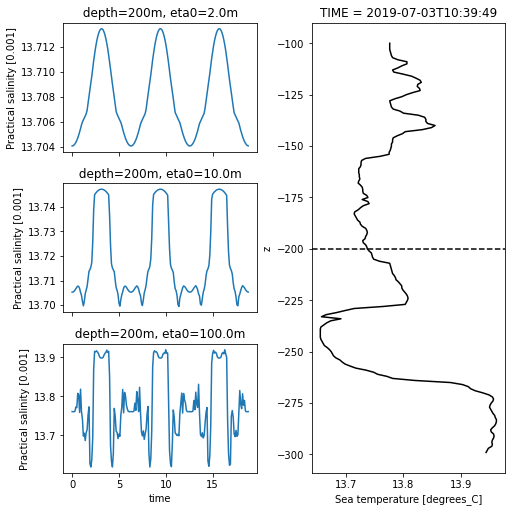

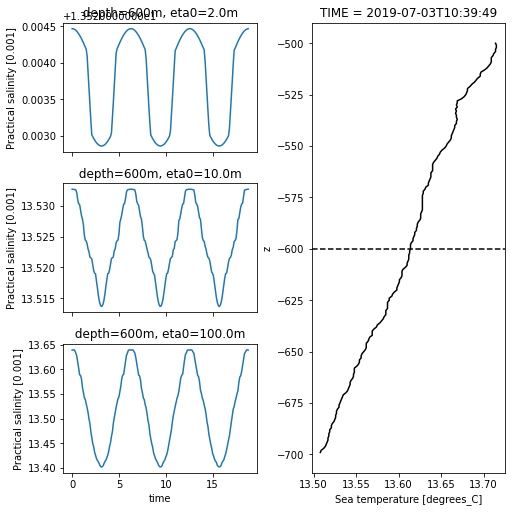

In [13]:
for d in dst.depth0:
    _ds = dst.sel(depth0=d)
    axes_left = range(_ds.eta0.size)
    fig, axd = plt.subplot_mosaic([[k, 'right'] for k in axes_left],
                              figsize=(7, 7), constrained_layout=True)
    #fig, axes = plt.subplots(,1,)
    for _eta, k in zip(_ds.eta0, axes_left):
        ax = axd[k]
        _ds["TEMP"].sel(eta0=_eta).plot.line(ax=ax, x="time")
        ax.set_title(f" depth={float(d):.0f}m, eta0={float(_eta):.1f}m ")
        if k is not axes_left[-1]:
            ax.set_xticklabels("")
            ax.set_xlabel("")
    # zoom on temperature profile
    ax = axd["right"]
    dsp["TEMP"].sel(depth=slice(int(d-eta0_max), int(d+eta0_max))).plot(ax=ax, y="z", color="k")
    ax.axhline(-float(d), color="k", ls="--")
    #ax.set_xlim(13.2, 14.2)
    #ax.set_xlim(13.2, 14.2)

---

## get internal wave properties

/var/folders/pb/vp119fcj1pn3dc3x2dz4dkt80000gn/T/ipykernel_87440/3236605237.py:2: AccessorRegistrationWarning: registration of accessor <class '__main__.InternalWave'> under name 'iw' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  class InternalWave:


---

## simple case: N=constant

In [86]:
f = 2*2*np.pi/86400*np.sin(np.pi/180*43)
N2 = 1e-6
cph = 3600/(2*np.pi)
cpd = 86400/(2*np.pi)

N = np.sqrt(N2)
N_max = N

kz0 = 2*np.pi/100

ds = xr.Dataset(dict(N=N,f=f),
                coords=dict(omega=("omega", np.linspace(f, N_max/2, 1000)),
                            kz=("kz", 2*np.pi/np.arange(10, 1000, 10))) # positive kz = downward propagating energy
               )
ds = ds.assign_coords(omega_cpd=ds.omega*cpd)
ds = ds.assign_coords(lambda_z=2*np.pi/ds.kz)

# reverse kx:
ds.iw.set_kx(-np.abs(ds.iw.kx))

#ds

In [87]:
ds["bathy_slope"] = ("bathy_slope", -np.array([10**k for k in range(-4,0)]))

In [88]:
kx_r, ky_r, kz_r, Q = ds.iw.reflected_wave(ds.bathy_slope, 0.)

Warning assumes ky=0 from now on


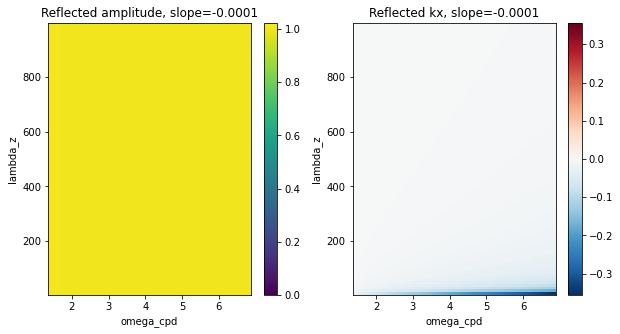

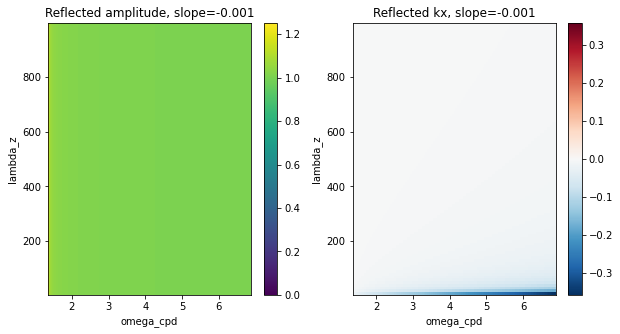

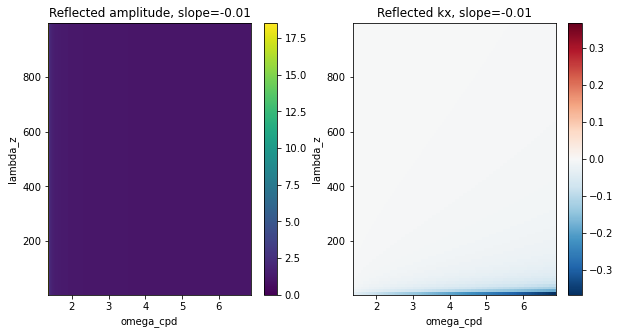

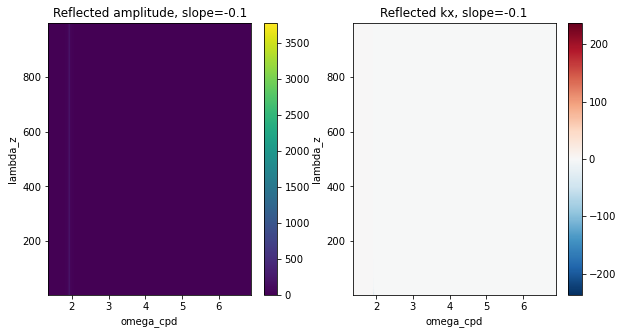

In [89]:
for s in ds.bathy_slope:
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    ax = axes[0]
    np.abs(Q.sel(bathy_slope=s)).plot(ax=ax, x="omega_cpd", y="lambda_z")
    ax.set_title(f"Reflected amplitude, slope={float(s)}")
    ax = axes[1]
    kx_r.sel(bathy_slope=s).T.plot(ax=ax, x="omega_cpd", y="lambda_z")
    ax.set_title(f"Reflected kx, slope={float(s)}")

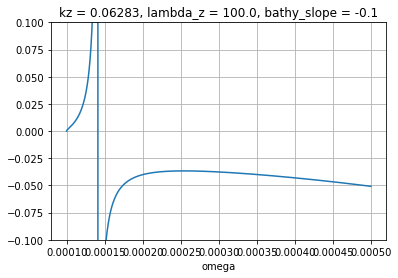

In [90]:
fig, ax = plt.subplots(1,1)
kx_r.sel(bathy_slope=-0.1, kz=kz0, method="nearest").plot()
ax.set_ylim(-.1,.1)
ax.grid()

In [101]:
ds["x"] = ("x", np.arange(0,10e3,1e2))

In [102]:
b = ds.iw.amplitude(ds.x, 0, -1000, variable="b") # kz x omega x x
b = b.sel(kz=kz0, method="nearest")

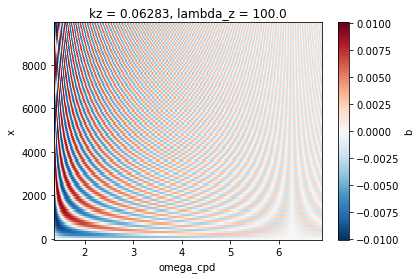

In [106]:
fig, ax = plt.subplots(1,1)
np.real(b).plot(x="omega_cpd")
#ax.set_xlim(1,2)

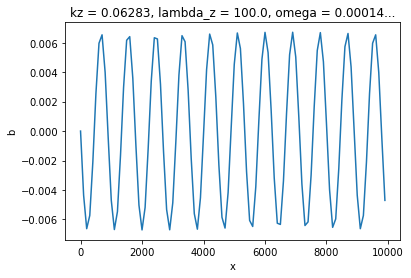

In [110]:
np.real(b).sel(omega=f*1.5, method="nearest").plot()

In [ ]:
# along slope

In [ ]:
b = ds.iw.amplitude(ds.x, 0, -1000, variable="b") # kz x omega x x

In [112]:
b_r = Q*ds.iw.amplitude(ds.x, 0, -1000, variable="b", kx=kx_r, ky=ky_r, kz=kz_r) # kz x omega x x

In [113]:
b_r

<xarray.DataArray (omega: 1000, kz: 99, bathy_slope: 4, x: 100)>
array([[[[ 0.00000000e+00-0.00000000e+00j,
           0.00000000e+00-0.00000000e+00j,
           0.00000000e+00-0.00000000e+00j, ...,
           0.00000000e+00-0.00000000e+00j,
           0.00000000e+00-0.00000000e+00j,
           0.00000000e+00-0.00000000e+00j],
         [            nan           +nanj,
                      nan           +nanj,
                      nan           +nanj, ...,
                      nan           +nanj,
                      nan           +nanj,
                      nan           +nanj],
         [ 0.00000000e+00-0.00000000e+00j,
           0.00000000e+00-0.00000000e+00j,
           0.00000000e+00-0.00000000e+00j, ...,
           0.00000000e+00-0.00000000e+00j,
           0.00000000e+00-0.00000000e+00j,
           0.00000000e+00-0.00000000e+00j],
         [ 0.00000000e+00-0.00000000e+00j,
           0.00000000e+00-0.00000000e+00j,
...
          -1.10485791e-03-1.66796807e-03j,
          -1.62075704e-03-1.17301964e-03j],
         [-1.72271348e-04+1.99967437e-03j,
           5.44002886e-04+1.93195131e-03j,
           1.19037423e-03+1.61597778e-03j, ...,
          -6.24829768e-04-1.90734443e-03j,
          -1.25733023e-03-1.56444741e-03j,
          -1.72826718e-03-1.02052317e-03j],
         [-5.96083217e-04+1.98436322e-03j,
           1.66092233e-04+2.06529077e-03j,
           9.05539434e-04+1.86360160e-03j, ...,
          -1.96013220e-03-6.71486669e-04j,
          -2.07012965e-03+8.70390353e-05j,
          -1.89684823e-03+8.33654220e-04j],
         [-9.89626618e-04-2.68183343e-03j,
          -2.17905655e-03-1.85021727e-03j,
          -2.80680764e-03-5.41684670e-04j, ...,
           3.41932740e-04-2.83807565e-03j,
          -1.09583639e-03-2.64021477e-03j,
          -2.25114011e-03-1.76180579e-03j]]]])
Coordinates:
  * omega        (omega) float64 9.919e-05 9.959e-05 0.0001 ... 0.0004996 0.0005
    omega_cpd    (omega) float64 1.364 1.37 1.375 1.381 ... 6.864 6.87 6.875
  * kz           (kz) float64 0.6283 0.3142 0.2094 ... 0.006411 0.006347
    lambda_z     (kz) float64 10.0 20.0 30.0 40.0 ... 960.0 970.0 980.0 990.0
  * bathy_slope  (bathy_slope) float64 -0.0001 -0.001 -0.01 -0.1
  * x            (x) float64 0.0 100.0 200.0 300.0 ... 9.7e+03 9.8e+03 9.9e+03

---

## with realistic stratification

In [15]:
f = 2*2*np.pi/86400*np.sin(np.pi/180*43)
N2 = 1e-6
cph = 3600/(2*np.pi)
cpd = 86400/(2*np.pi)

N = np.sqrt(N2)
N_max = N

if True:
    N = np.sqrt(ds_smooth["N2"].isel(TIME=0)).rename(dict(DEPTH_MID="depth", z_mid="z")).rename("N")

ds = xr.Dataset(dict(N=N,f=f),
                coords=dict(omega=("omega", np.linspace(f, N_max/2, 1000)),
                            kz=("kz", -2*np.pi/np.arange(10, 1000, 10)))
               )
# Lz=("z", np.arange(10, 1000, 10)),
ds = ds.assign_coords(omega_cpd=ds.omega*cpd)
ds = ds.assign_coords(lambda_z=2*np.pi/ds.kz)
ds

<xarray.Dataset>
Dimensions:    (depth: 33, omega: 1000, kz: 99)
Coordinates:
  * depth      (depth) float64 15.0 45.0 75.0 105.0 ... 885.0 915.0 945.0 975.0
    TIME       datetime64[ns] 2019-07-03T10:39:49
    z          (depth) float64 -15.0 -45.0 -75.0 -105.0 ... -915.0 -945.0 -975.0
  * omega      (omega) float64 9.919e-05 9.959e-05 0.0001 ... 0.0004996 0.0005
  * kz         (kz) float64 -0.6283 -0.3142 -0.2094 ... -0.006411 -0.006347
    omega_cpd  (omega) float64 1.364 1.37 1.375 1.381 ... 6.859 6.864 6.87 6.875
    lambda_z   (kz) float64 -10.0 -20.0 -30.0 -40.0 ... -970.0 -980.0 -990.0
Data variables:
    N          (depth) float64 0.02569 0.01055 0.005816 0.004875 ... nan nan nan
    f          float64 9.919e-05

In [16]:
ds.iw.kx(sign=-1)
#ds.iw._kx.isel(omega=)

/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


<xarray.DataArray 'kx' (kz: 99, omega: 1000, depth: 33)>
array([[[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
                     nan,             nan,             nan],
        [-2.18436143e-04, -5.31668076e-04, -9.65007942e-04, ...,
                     nan,             nan,             nan],
        [-3.09226957e-04, -7.52650859e-04, -1.36610545e-03, ...,
                     nan,             nan,             nan],
        ...,
        [-1.19687734e-02, -2.91577459e-02, -5.30541666e-02, ...,
                     nan,             nan,             nan],
        [-1.19787917e-02, -2.91821957e-02, -5.30988755e-02, ...,
                     nan,             nan,             nan],
        [-1.19888096e-02, -2.92066448e-02, -5.31435838e-02, ...,
                     nan,             nan,             nan]],

       [[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
                     nan,             nan,             nan],
        [-1.09218071e-04, -2.65834038e-04, -4.82503971e-04, ...,
                     nan,             nan,             nan],
        [-1.54613479e-04, -3.76325430e-04, -6.83052725e-04, ...,
                     nan,             nan,             nan],
...
        [-1.22130341e-04, -2.97528019e-04, -5.41369047e-04, ...,
                     nan,             nan,             nan],
        [-1.22232568e-04, -2.97777507e-04, -5.41825261e-04, ...,
                     nan,             nan,             nan],
        [-1.22334792e-04, -2.98026988e-04, -5.42281467e-04, ...,
                     nan,             nan,             nan]],

       [[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
                     nan,             nan,             nan],
        [-2.20642568e-06, -5.37038460e-06, -9.74755497e-06, ...,
                     nan,             nan,             nan],
        [-3.12350462e-06, -7.60253393e-06, -1.37990449e-05, ...,
                     nan,             nan,             nan],
        ...,
        [-1.20896701e-04, -2.94522686e-04, -5.35900673e-04, ...,
                     nan,             nan,             nan],
        [-1.20997895e-04, -2.94769653e-04, -5.36352278e-04, ...,
                     nan,             nan,             nan],
        [-1.21099087e-04, -2.95016614e-04, -5.36803877e-04, ...,
                     nan,             nan,             nan]]])
Coordinates:
    TIME       datetime64[ns] 2019-07-03T10:39:49
  * kz         (kz) float64 -0.6283 -0.3142 -0.2094 ... -0.006411 -0.006347
    lambda_z   (kz) float64 -10.0 -20.0 -30.0 -40.0 ... -970.0 -980.0 -990.0
  * omega      (omega) float64 9.919e-05 9.959e-05 0.0001 ... 0.0004996 0.0005
    omega_cpd  (omega) float64 1.364 1.37 1.375 1.381 ... 6.859 6.864 6.87 6.875
  * depth      (depth) float64 15.0 45.0 75.0 105.0 ... 885.0 915.0 945.0 975.0
    z          (depth) float64 -15.0 -45.0 -75.0 -105.0 ... -915.0 -945.0 -975.0

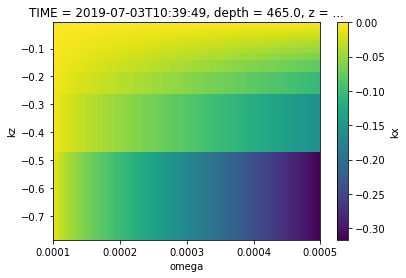

In [17]:
ds.iw._kx.isel(depth=15).plot()

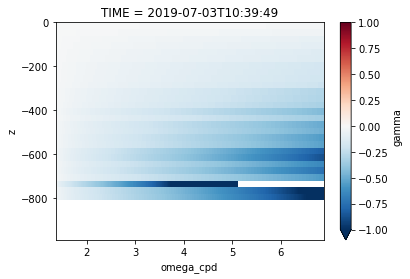

In [18]:
ds.iw.kx(sign=-1)
ds.iw.gamma.plot(x="omega_cpd", y="z", vmax=1)

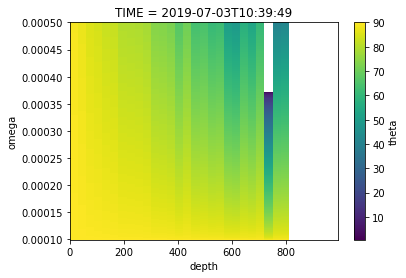

In [19]:
(ds.iw.theta*180/np.pi).plot()

Text(0.5, 1.0, 'horizontal wavelength [km] \n f = 1.4 cpd (=17.6 hours), N = 15.5 cpd (=1.5 hours)')

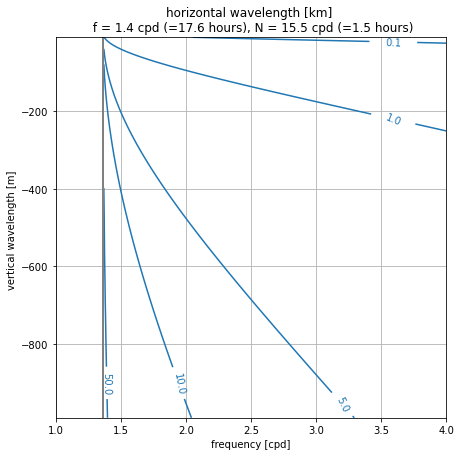

In [20]:
fig, ax = plt.subplots(1,1, figsize=(7,7))

_ds = ds.sel(depth=500., method="nearest")

CS = (2*np.pi/_ds.iw.kx()/1e3
     ).T.plot.contour(x="omega_cpd", y="lambda_z",
                      colors="C0", 
                      levels=[.1, 1, 5, 10, 50],
                     ) # weird necessary transposition
ax.clabel(CS, inline=1, fontsize=10)
ax.axvline(f*cpd, color="0.5", lw=2)
ax.set_xlim(1,4)
ax.grid()
ax.set_xlabel("frequency [cpd]")
ax.set_ylabel("vertical wavelength [m] ")

_N = float(_ds.N)
ax.set_title(f"horizontal wavelength [km] \n f = {f*cpd:.1f} cpd (={1/f/cph:.1f} hours), N = {_N*cpd:.1f} cpd (={1/_N/cph:.1f} hours)")

---

## Generate a synthetic bathymetry

Inspired from Toulon cable

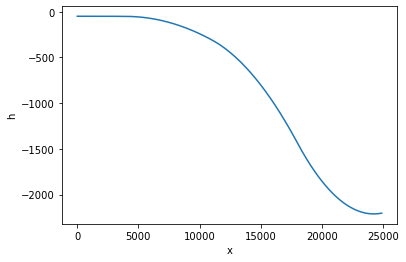

In [21]:
#bathy = xr.Dataset({"x": np.arange(0,20e3,100), "xbathy"})
bathy = (xr.Dataset({"x": ("x", [0, 1e3, 7e3, 15e3, 21e3, 25e3]), 
                     "h":("x", [50, 50, 100, 800, 2e3, 2.2e3])},
                   )
         .interp(x=np.arange(0,25e3,100), method="quadratic")
        )
# compute the slope: dz/dx (to match Gerkema's convention)
bathy["bathy_slope"] = -bathy.h.differentiate("x")

(-bathy["h"]).plot()

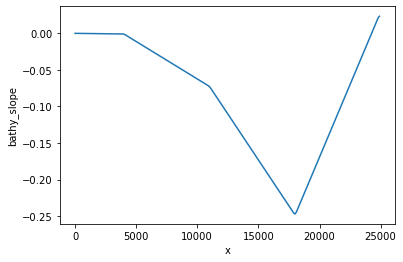

In [22]:
bathy["bathy_slope"].plot()

---
## merge with stratification and internal wave properties


In [23]:
ds_bathy = xr.merge([ds, bathy])

/Users/aponte/.miniconda3/envs/cognac/lib/python3.8/site-packages/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


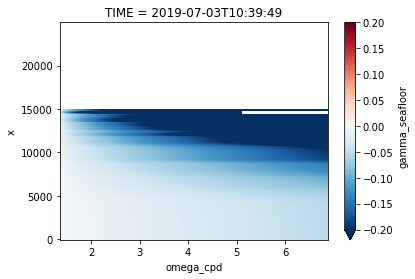

In [24]:
# compute gamma at the seafloow
ds_bathy["gamma_seafloor"] = ds_bathy.iw.gamma.interp(depth=ds_bathy.h)
ds_bathy["gamma_seafloor"].plot(x="omega_cpd", vmax=.2)

Identify where wave bounce back against the bottom, i.e. supercritical areas, in frequency - range space

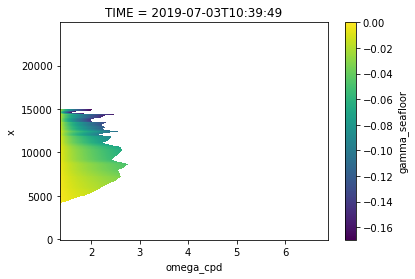

In [25]:

#gamma_subcritical = ds_bathy.gamma_seafloor.where(ds_bathy.gamma_seafloor>ds_bathy.bathy_slope)
gamma_supercritical = ds_bathy.gamma_seafloor.where(np.abs(ds_bathy.gamma_seafloor)<np.abs(ds_bathy.bathy_slope))
gamma_supercritical.plot(x="omega_cpd")

In [27]:
#ds_bathy.iw._kx
# _kw is None

In [26]:
ds_bathy.iw.reflected_wave(-.1, 0.)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

In [26]:
ds_bathy.iw.amplitude(ds_bathy.x, 0, -1000)

Signature:
ds_bathy.iw.amplitude(
    x,
    y,
    z,
    variable='w',
    kx=None,
    ky=None,
    kz=None,
    amplitude=1.0,
)
Docstring:
Evaluate the complex amplitude of the internal wave

e^[i (x kx + y ky + z kz - omega t) ]

Parameters
----------
x,y,z: float, xr.DataArray
    Coordinates where the amplitude has to be evaluated
variable: str, optional
    Variable corresponding to the desired amplitude, e.g. "w", "b", ...
kx, ky, kz: float, xr.DataArray, optional
    Manually set wavenumbers (useful for reflected configurations)
amplitude: float, xr.DataArray, optional
    Manually set amplitude (useful for reflected configurations)
File:      /var/folders/pb/vp119fcj1pn3dc3x2dz4dkt80000gn/T/ipykernel_87209/767660381.py
Type:      method


---

## reflection against the bottom and bottom trapped waves


---

## old stuff

In [ ]:
def get_k_spherical(k):
    """ compute the angle made by the wavenumber with the horizontal plane
    in radians
    
    Parameters:
    k: tuple
        wavenumbers (kx, ky, kz)
        
    Returns
    -------
    
    """
    x, y, z = k
    hxy = np.hypot(x, y)
    kappa = np.hypot(hxy, z)
    theta = np.arctan2(z, hxy)
    phi = np.arctan2(y, x)
    if isinstance(kappa, xr.DataArray):
        kappa = kappa.rename("kappa")
    if isinstance(theta, xr.DataArray):
        theta = theta.rename("theta")
    if isinstance(phi, xr.DataArray):
        phi = phi.rename("phi")
    return kappa, theta, phi

def get_cotan2_theta(omega, N, f):
    cotan2_theta = (omega**2-f**2)/(N**2-omega**2)
    return cotan2_theta

def get_theta(omega, N, f):
    theta = np.arctan(1/np.sqrt(get_cotan2_theta(omega, N, f)))
    return theta

def get_omega2(N, f, theta=None, k=None):
    """ compute the square internal wave frequency
    """
    assert theta is not None or k is not None, "theta or wavenumber k has to be provided"
    if theta is None:
        kappa, theta, phi = get_k_spherical(k)
    omega2 = (N * np.cos(theta))**2 + (f*np.sin(theta))**2
    #if isinstance(omega2, xr.DataArray):
    #    omega2 = omega2.rename("omega2")
    return omega2


def get_kh(omega, N, f, kz):
    """ get horizontal wavenumber
    The sign may set either way afterward
    
    k/m = cotan(theta)

    """
    cotan2_theta = get_cotan2_theta(omega, N, f)
    kh = np.abs(kz) * np.sqrt(cotan2_theta)
    return kh


def get_kz(omega, N, f, kh):
    """ get vertical wavenumber
    The sign may set either way afterward
    
    m/k = tan(theta)

    """
    cotan2_theta = get_cotan2_theta(omega, N, f)
    if isinstance(kh, tuple):
        kh = np.sqrt(kh[0]**2+kh[1]**2)
    kz = np.abs(kh) / np.sqrt(cotan2_theta)
    return kz
    
def get_cg(N, f, k):
    """ return the internal wave group speed
    
    Parameters
    ----------
    N: float, xr.DataArray
    ...
    """
    kappa, theta, phi = get_k_spherical(k)
    omega = np.sqrt(get_omega2(N, f, theta=theta, k=k))
    cg = (N**2-f**2) * np.cos(theta)*np.sin(theta)/kappa/omega
    cg_vector = (cg*np.sin(theta)*np.cos(phi), 
                 cg*np.sin(theta)* np.sin(phi),
                 -cg*np.cos(theta),
                )
    if isinstance(cg_vector[0], xr.DataArray):
        cg_vector = tuple(c.rename("cg_"+d) for c, d in zip(cg_vector, ["x", "y", "z"]) )
    return cg, cg_vector